# Build a LSTM to language translation
* https://colah.github.io/posts/2015-08-Understanding-LSTMs/
* https://blog.mlreview.com/understanding-lstm-and-its-diagrams-37e2f46f1714
* https://medium.com/@saikrishna4820/lstm-language-translation-18c076860b23
* https://www.analyticsvidhya.com/blog/2019/01/neural-machine-translation-keras/?

LSTMs are a kind of RRN to sequence to sequence model containing two subcategories are sequence to sequence of same length,eg: parts of speech detection for each input word. sequence to sequence of different length, eg: language translation model.

Our objective is convert German sentence to its English counterpart using a Neural Machine Translation (NMT) system, in this case LSTM, seq2seq model. We will use the dataset in [http://www.manythings.org/anki/](http://www.manythings.org/anki/) and we will use the Tensorflow library.


## To run in Colab


In [1]:

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
drive_path = '/content/drive/Othercomputers/My Laptop/DRIVE/transformer/lstm'

%cd /content/drive/Othercomputers/My Laptop/DRIVE/transformer/lstm


Mounted at /content/drive
/content/drive/Othercomputers/My Laptop/DRIVE/transformer/lstm


## Coding seq2seq model

A typical seq2seq model has 2 major components: Encoding and Decoding.

**Encoder** takes all input data, perform simple Rnn on the data and passes the last state of its recurrent layer to the decoder layer. it is done easily using keras. you learn more details of encoding and decoding here.

**Decoder** initializes its first layer by the last layer of encoder, the output of decoder is the sequence of words that we want to get.

![arquitecture](resources/rnn-encoder-decoder.jpj)

In [2]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
import numpy as np

from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option("display.max_colwidth", 200)
import warnings

warnings.filterwarnings("ignore")


## Load the data

In [3]:
import numpy as np


import re
import pandas as pd
from numpy import array


# function to read raw text file
def read_text(filename):
    # open the file
    with open(filename, mode="rt", encoding="utf-8") as file:
        text = file.read()
    return text


# Let’s define another function to split the text into English-German pairs
# separated by ‘\n’. We’ll then split these pairs into English sentences and
 #German sentences respectively.


def to_lines(text):
    sents = text.strip().split("\n")
    sents = [i.split("\t") for i in sents]
    return sents


# We can now use these functions to read the text into an array in our desired format.

# data = read_text("../resources/deu.txt") #to run in local
data = read_text("deu.txt") # to run from colab
deu_eng = to_lines(data)
deu_eng = [(row[0], row[1]) for row in deu_eng]
deu_eng = array(deu_eng)

# The actual data contains over 150,000 sentence-pairs. However, we will use only the first 70,000 sentence pairs to reduce the training time of the model.
# np.random.seed(42)
# indices = np.random.permutation(deu_eng.shape[0])[:70000]

deu_eng = deu_eng[:70000]
deu_eng

array([['Go.', 'Geh.'],
       ['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ...,
       ["I'll ask you once more.", 'Ich frage Sie noch einmal.'],
       ["I'll ask you once more.", 'Ich frage euch noch einmal.'],
       ["I'll be around all day.", 'Ich bin den ganzen Tag da.']],
      dtype='<U537')

In [4]:
eng = [
    sentence.lower().replace("[{}]".format(string.punctuation), "")
    for sentence in deu_eng[:, 0]
]
deu = [
    sentence.lower().replace("[{}]".format(string.punctuation), "")
    for sentence in deu_eng[:, 1]
]
assert len(eng) == len(deu)

# remove_list has rows of empty values
eng_deu = np.array([(x,y) for x, y in zip(eng, deu) if x and y])
eng_deu.shape

(70000, 2)

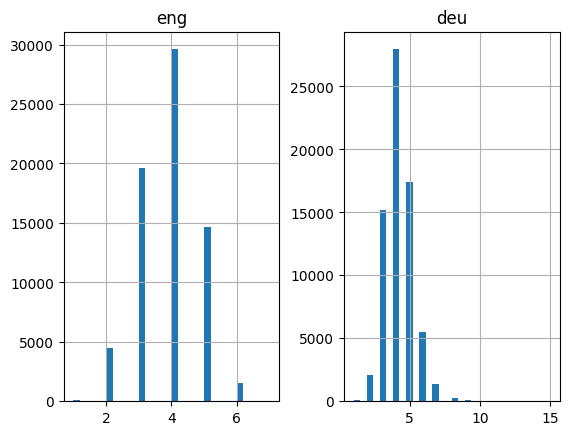

Maximum Sequence Lenght in English:  7
Maximum Sequence Lenght in German:  15


In [5]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in eng_deu[:,0]:
      eng_l.append(len(i.split()))

for i in eng_deu[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

ax = length_df.hist(bins = 30)


plt.show()
print("Maximum Sequence Lenght in English: ", max(eng_l))
print("Maximum Sequence Lenght in German: ", max(deu_l))

## Tokenizer

In [6]:
from keras.preprocessing.text import Tokenizer


def tokenization(lines):
    """function to build a tokenizer"""
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer


# prepare english tokenizer
eng_tokenizer = tokenization(eng_deu[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

# prepare Deutch tokenizer
deu_tokenizer = tokenization(eng_deu[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

eng_length = 8
deu_length = 16

print("English Vocabulary Size: %d" % eng_vocab_size)
print("Deutch Vocabulary Size: %d" % deu_vocab_size)


English Vocabulary Size: 7347
Deutch Vocabulary Size: 12474


In [7]:
from keras.preprocessing.sequence import pad_sequences

def encode_sequences(tokenizer, length, lines):
    """ function ti encode and pad sequences"""
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

## Model Building
* For the encoder, we will use an embedding layer and an LSTM layer
* For the decoder, we will use another LSTM layer followed by a dense layer


![arch_seq2seq](resources/architecture_seq2seq.webp)

In [8]:
# split data into train and test set
from sklearn.model_selection import train_test_split


train, test = train_test_split(eng_deu, test_size=0.2, random_state = 12)

# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [9]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector


def define_model(in_vocab, out_vocab, in_seq, out_seq, units):
    """Function to build seq2seq model using as encoder and decoder a LSTM cell

    Args:
      in_vocab: size of input vocabulary
      out_vocab: size of output vocabulary
      in_seq: input sequence length
      out_seq: output sequence length
      units:  are the dimension of the embeddings vectors and
        thedimension of the hidden state (or the output) for the LSTM cell.
    """

    model = Sequential()

    # mask_zero=True to indicate that ignore the pad tokens
    model.add(Embedding(in_vocab, units, input_length=in_seq, mask_zero=True))
    model.add(LSTM(units)) # encoder
    model.add(RepeatVector(out_seq))
    model.add(LSTM(units, return_sequences=True)) # decoder
    # after of decoder the outputs have the dimension (batch_size, out_seq, units),
    # it represents a feature vector of dimension `units`
    # for each element in the sequence and for each element in the batch
    model.add(Dense(out_vocab, activation="softmax"))
    return model


In [10]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

We have used **sparse_categorical_crossentropy** as the loss function. This is because the function allows us to use the target sequence as is, instead of the one-hot encoded format. One-hot encoding the target sequences using such a huge vocabulary might consume our system’s entire memory.

In [ ]:
filename = "model_lstm.h5"
checkpoint = ModelCheckpoint(
    filename, monitor="val_loss", verbose=1, save_best_only=True, mode="min"
)

# train model
history = model.fit(
    trainX,
    trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
    epochs=60,
    batch_size=512,
    validation_split=0.2,
    callbacks=[checkpoint],
    verbose=1,
)


Epoch 1/60
88/88 [==============================] - ETA: 0s - loss: 4.1176
Epoch 1: val_loss improved from inf to 3.10230, saving model to model_lstm.h5
88/88 [==============================] - 63s 665ms/step - loss: 4.1176 - val_loss: 3.1023
Epoch 2/60
88/88 [==============================] - ETA: 0s - loss: 2.9943
Epoch 2: val_loss improved from 3.10230 to 2.93778, saving model to model_lstm.h5
88/88 [==============================] - 43s 492ms/step - loss: 2.9943 - val_loss: 2.9378
Epoch 3/60
88/88 [==============================] - ETA: 0s - loss: 2.9058
Epoch 3: val_loss improved from 2.93778 to 2.93048, saving model to model_lstm.h5
88/88 [==============================] - 43s 492ms/step - loss: 2.9058 - val_loss: 2.9305
Epoch 4/60
88/88 [==============================] - ETA: 0s - loss: 2.8717
Epoch 4: val_loss improved from 2.93048 to 2.87914, saving model to model_lstm.h5
88/88 [==============================] - 43s 494ms/step - loss: 2.8717 - val_loss: 2.8791
Epoch 5/60
88/88

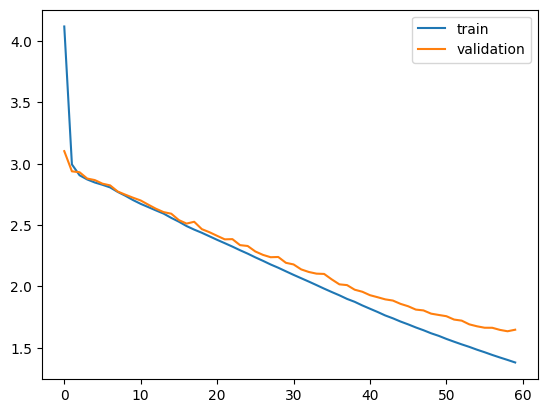

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [ ]:
from keras.models import load_model

# Load the best model
model = load_model('model_lstm.h5')


# map an integer to a word
def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

# generate target given source sequence
def predict_sequence(model, tokenizer, source):
  prediction = model.predict(source, verbose=0)[0]
  integers = [argmax(vector) for vector in prediction]
  target = list()
  for i in integers:
    word = word_for_id(i, tokenizer)
    if word is None:
      break
    target.append(word)
  return ' '.join(target)


In [ ]:
import pandas as pd

def evaluate_model(model, tokenizer, sources, raw_dataset):
    # Crear un diccionario para almacenar los resultados
    results = {'source': [], 'target': [], 'predicted': []}

    for i, source in enumerate(sources):
        # Traducir el texto fuente codificado
        source = source.reshape((1, source.shape[0], 1))
        translation = predict_sequence(model, tokenizer, source)
        raw_target, raw_src = raw_dataset[i]

        results['source'].append(raw_src)
        results['target'].append(raw_target)
        results['predicted'].append(translation)

    results_df = pd.DataFrame(results)

    return results_df


results = evaluate_model(model, eng_tokenizer, testX[:20], test[:20])
results.head(25)


,source,target,predicted
0,ich bade.,i'm taking a bath.,i am a
1,tom ist romantisch.,tom is romantic.,tom is a
2,dieses buch ist klein.,that book is small.,this car is new
3,sie sind in tränen ausgebrochen.,they burst into tears.,you're in in
4,betrübt dich das?,does that make you sad?,get it
5,"ich hätte gern, dass du es siehst.",i'd like you to see it.,i think you like you
6,ich habe einen stiefbruder.,i have a stepbrother.,i have a
7,wir werden es tom sagen.,we'll tell tom.,we'll tell tom tom
8,ich habe niemals mit tom gesprochen.,i never talked to tom.,i never with tom tom
9,sie kann gut kochen.,she cooks well.,you may be very


## Conslusion

our Seq2Seq model does a decent job. But there are several instances where it misses out on understanding the key words. For example, it translates “im tired of boston” to “im am boston”.

These are the challenges you will face on a regular basis in NLP. But these aren’t immovable obstacles. We can mitigate such challenges by using more training data and building a better (or more complex) model.